### Anomaly Detection
- To indentify the data points that are different of the other data point
- There are 3 categories
    - Supervised Anomaly Dection: labels for both nomal and anomalous data
    - Semi-Supervised Anomaly Dectection: only label of nomal data 
    - Unsupervise Anomaly Dectection: no label is available
- Algorithms
    - Mahalanobis Distance: 
        - For one single dimension data, z-score can be used for outlier/anomaly detection. A data point is labeled as an anomaly if |z| > T (Threshold)
        - For multidimensional data, the z-score is not applicable. The Mahalanobis distance defined as https://en.wikipedia.org/wiki/Mahalanobis_distance
        
    - Density-based spatial clustering of application with noise (DBSCAN)
    - Local Outlier Factor (LOF)
    - Isolation Forest
    - One-Class Support Vector Machine

In [42]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# make dataset
from sklearn.datasets import make_blobs

# statistical modules for data generation and critical values
from scipy.stats import multivariate_normal, beta, uniform, t

from functools import partial

from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.covariance import EllipticEnvelope # use for Mohalanobis distance
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

from typing import Any


In [43]:
class MahalanobisOutlier(EllipticEnvelope):

    def __init__(self, *, store_precision = True, assume_centered = False, support_fraction = None, contamination = 0.1, alpha:float = 0.05, random_state = None, ) -> None:
        super().__init__(store_precision = store_precision,
                         assume_centered = assume_centered,
                         support_fraction = support_fraction,
                         contamination = contamination,
                         random_state = random_state,)
        self.alpha = alpha

    def predict(self, X):
        dist = self.mahalanobis(X = X)
        p = self.location_.shape[0] # dimension
        n = self.support_.shape[0] # number of sample

        if p > 1:
            Tm = ((n - 1) ** 2)/n
            alpha = self.alpha
            b = beta.ppf(1 - alpha, a = p/2, b = (n - p - 1)/2) # return quantile corresponding to the lower tail probability
            Tm = Tm * b
            inliers = 2 * (dist <= Tm).astype('int') - 1 # -1v for anomalies/outliers, +1 for inliers
        else: # one dimension use Gubb's test
            Tm = ((n - 1) ** 2)/n
            t_sq = t.ppf(1 - alpha/2.0, df = n - 2) ** 2
            th = t_sq/(n - 2 - t_sq)
            Tm = Tm * th
            inliers = 2 * (dist <= Tm).astype('int') - 1
        return inliers
    
    def decision_func(self, X:np.ndarray) -> np.ndarray:
        p = self.location_.shape[0] # dimension
        n = self.support_.shape[0] # number of sample

        if p > 1:
            Tm = ((n - 1) ** 2)/n
            alpha = self.alpha
            b = beta.ppf(1 - alpha, a = p/2, b = (n - p - 1)/2) # return quantile corresponding to the lower tail probability
            Tm = Tm * b
        else: # one dimension use Gubb's test
            Tm = (n - 1)/np.sqrt(n)
            t_sq = t.ppf(1 - alpha/2.0, df = n - 2) ** 2
            th = np.sqrt(t_sq/(n - 2 - t_sq))
            Tm = Tm * th
        score = -self.mahalanobis(X = X) + Tm
        return score           
    

In [44]:
# alpha: The significace value for detecting anomaly
# contamination: The portion of training data that may be outlier or anormalies

alpha = 0.01
contamination = 0.01

clf = MahalanobisOutlier(contamination = contamination, alpha = alpha)

In [45]:
clf

MahalanobisOutlier(alpha=0.01, contamination=0.01)

In [46]:
# create a dataset that have points from a single multivariate Gaussion population, then manuallu add a outlier into a dataset

np.random.seed(0) # random seed = 0
n = 1000 # 1000 samples
mu = np.array([0, 0]) # zero means
sigma = np.array([
    [2, 1],
    [1, 2]
])
sigma

array([[2, 1],
       [1, 2]])

In [47]:
sigma.shape

(2, 2)

In [48]:
normal = multivariate_normal.rvs(mean = mu, cov = sigma, size = n) # rvs: random variates of size (size, N), where N is the dimension of the random variable
normal

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-0.31140929, -0.17316878],
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187]])

In [49]:
len(normal)

1000

In [50]:
anomaly = np.array([3, 3])
anomaly

array([3, 3])

In [51]:
anomaly = np.array([3, 3]).reshape(-1, 2) # anomaly data popint
anomaly

array([[3, 3]])

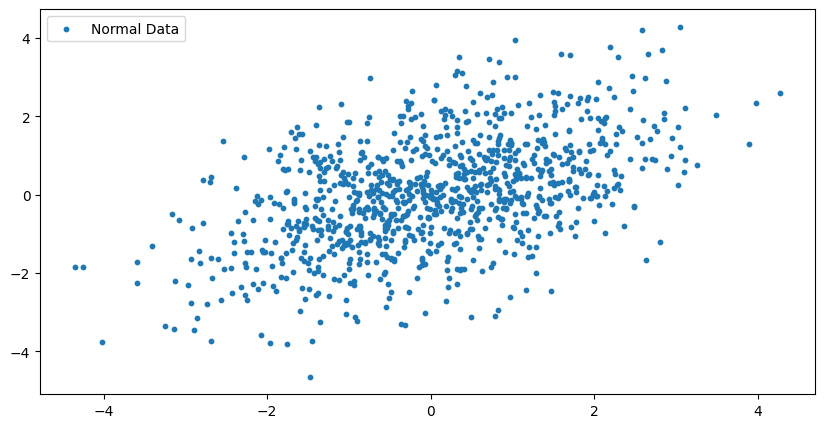

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(normal[:, 0], normal[:, 1], s = 10, label = 'Normal Data')

ax.legend()

Text(0.5, 1.0, 'Unimodal Data with Single Anomaly')

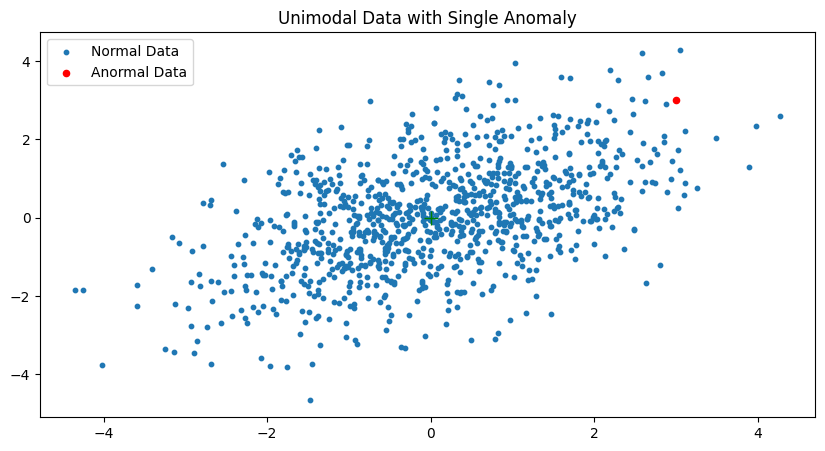

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.scatter(normal[:, 0], normal[:, 1], s = 10, label = 'Normal Data')
ax.plot([0], [0], marker = '+', color = 'green', markersize = 10) # mark the center
ax.scatter(anomaly[:, 0], anomaly[:, 1], s = 20, color = 'red', label = 'Anormal Data') # add anomaly data point

ax.legend()
ax.set_title('Unimodal Data with Single Anomaly')

In [54]:
# concate normal and anomaly together

dataset1 = np.concatenate((normal, anomaly)) # last item is the anomaly
dataset1

array([[-2.44346794, -1.87756019],
       [-2.7832551 ,  0.38584645],
       [-1.59624225, -2.97832189],
       ...,
       [-1.82853826, -1.60447897],
       [ 2.32553395,  0.47154187],
       [ 3.        ,  3.        ]])

In [55]:
# create labels: 0 for nomal, 1 for anomaly

label = np.concatenate([(np.zeros(n, )), np.ones(1, )])  # last item is the anomaly
label

array([0., 0., 0., ..., 0., 0., 1.])

In [56]:
len(label)

1001

In [57]:
# setting for Mahalanobis Distance for Anomaly Detection

alpha = 0.001 # significance level for detecting anomalies
contamination = 0.001 # portion of anomalies in the training data

In [58]:
# create the model

clf_mahal = MahalanobisOutlier(contamination = contamination, alpha = alpha, random_state = 0) # set the random state to get the same result
clf_mahal

MahalanobisOutlier(alpha=0.001, contamination=0.001, random_state=0)

In [59]:
# train/fit the model

clf_mahal.fit(dataset1)

MahalanobisOutlier(alpha=0.001, contamination=0.001, random_state=0)

In [60]:
# Decision boundary and anomaly output

dataset = dataset1
normal_data = normal
anomaly_data = anomaly

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 1000

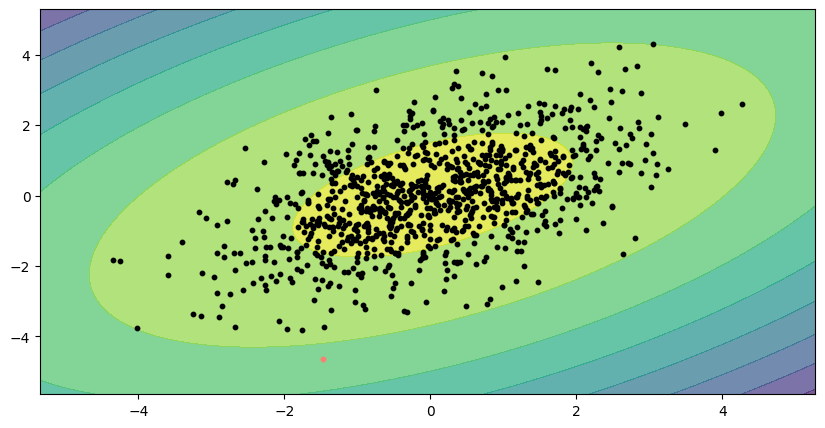

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5)) # make subplot of size 10x5

disp = DecisionBoundaryDisplay.from_estimator(clf_mahal, # anomaly detector
                                              dataset, # dataset for drawing decision boundary
                                              response_method = "decision_function", # plot decision function
                                              alpha = 0.7, # transparent level
                                              ax = ax)

pred = clf_mahal.predict(normal_data) # predict 
disp.ax_.scatter(normal_data[pred == 1, 0], normal_data[pred == 1, 1], s = 10, color = 'black', label = "True Normal")
disp.ax_.scatter(normal_data[pred == -1, 0], normal_data[pred == -1, 1], s = 10, color = 'salmon', label = "False Anomaly")

preda = clf_mahal.predict(anomaly_data) # predict 
disp.ax_.scatter(anomaly_data[pred == -1, 0], anomaly_data[pred == -1, 1], s = 10, color = 'red', label = "True Anomaly")
disp.ax_.scatter(anomaly_data[pred == 1, 0], anomaly_data[pred == 1, 1], s = 10, color = 'blue', label = "False Normal")

disp.ax_.set_title(r"Decision Boundary of Mahalanobis Distance ($\alpha=$ {})").format(alpha)
plt.axis("Square")
plt.colorbar(disp.ax_.collectons[1])
plt.legend()